#### Cash Coach

This app helps you manage your finances by analyzing your transaction data, visualizing spending patterns, and forecasting your future net amounts.

### Dependencies

In [13]:
#r "nuget: Microsoft.Data.SqlClient, *-*"
#r "nuget:ScottPlot, 5.0.*"

Error: ScottPlot version 5.0.* cannot be added because version 5.0.55 was added previously.

This is a C# implementation of the above code with graphing features

#### Enter a person's name

In [2]:
#!set --name personName --value @input:"Enter a person's name"

Error: Input request cancelled

Error: Input not provided.

#### Choose a random person's name

In [14]:
using System.IO;
using System.Data;
using Microsoft.Data.SqlClient;
using ScottPlot;
using Microsoft.DotNet.Interactive.Formatting;

var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\BestFunds.txt");

string personName;

using (var connection = new SqlConnection(connectionString))
using (var command = connection.CreateCommand())
{
    connection.Open();
    command.CommandType = CommandType.Text;
    command.CommandText = "select top 1 PersonName from Transactions order by newid()";

    personName = (await command.ExecuteScalarAsync()).ToString();
}

Console.WriteLine($"Randomly chose {personName}");

Randomly chose Tyler Garcia


#### Search our database and populate some data about that person

In [15]:
using System.IO;
using System.Data;
using Microsoft.Data.SqlClient;
using ScottPlot;
using Microsoft.DotNet.Interactive.Formatting;

Formatter.Register(typeof(ScottPlot.Plot), (p, w) => 
    w.Write(((ScottPlot.Plot)p).GetPngHtml(800, 600)), HtmlFormatter.MimeType);

public class Transaction
{
    public int Id { get; set; }
    
    public DateTime Date { get; set; }

    public DateTime TimeStamp { get; set; }

    public string PersonName { get; set; }

    public string Outlet { get; set; }

    public string Category { get; set; }

    public decimal Amount { get; set; }

    public string TransactionType { get; set; }

    public override string ToString() => $"{PersonName} {(TransactionType == "expense" ? "spent" : "gained")} £{Amount} on {Outlet} Transaction id {Id}.";
}

public async Task<List<Transaction>> GetTransactions(string sqlQuery)
{
    var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\BestFunds.txt");

    using (var connection = new SqlConnection(connectionString))
    using (var command = connection.CreateCommand())
    {
        connection.Open();
        command.CommandType = CommandType.Text;
        command.CommandText = sqlQuery;

        using var reader = await command.ExecuteReaderAsync();

        var result = new List<Transaction>();

        while (await reader.ReadAsync())
        {
            result.Add(new Transaction
            {
                Id = (int)reader["Id"],
                Date = (DateTime)reader["Date"],
                TimeStamp = (DateTime)reader["TimeStamp"],
                PersonName = (string)reader["PersonName"],
                Outlet = (string)reader["Outlet"],
                Category = (string)reader["Category"],
                Amount = (decimal)reader["Amount"],
                TransactionType = (string)reader["TransactionType"],
            });
        }

        return result;
    }
}

public async Task<List<(decimal Amount, string VendorName)>> GetGroupedAmounts(string sqlQuery)
{
    var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\BestFunds.txt");

    using (var connection = new SqlConnection(connectionString))
    using (var command = connection.CreateCommand())
    {
        connection.Open();
        command.CommandType = CommandType.Text;
        command.CommandText = sqlQuery;

        using var reader = await command.ExecuteReaderAsync();

        var result = new List<(decimal, string)>();

        while (await reader.ReadAsync())
        {
            result.Add(((decimal)reader["Amount"], (string)reader["Category"]));
        }

        return result;
    }
}

public async Task<List<(decimal Amount, DateTime Date, string Outlet)>> GetLargeExpenses(string sqlQuery)
{
    var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\\BestFunds.txt");
    var results = new List<(decimal, DateTime, string)>();

    using (var connection = new SqlConnection(connectionString))
    using (var command = connection.CreateCommand())
    {
        connection.Open();
        command.CommandType = CommandType.Text;
        command.CommandText = sqlQuery;

        using var reader = await command.ExecuteReaderAsync();
        while (await reader.ReadAsync())
        {
            decimal amount = (decimal)reader["Amount"];
            DateTime date = (DateTime)reader["Date"];
            string outlet = reader["Outlet"].ToString();
            results.Add((amount, date, outlet));
        }
    }
    return results;
}

public async Task<List<(decimal Amount, string Outlet, string Category)>> GetRecurringTransactions(string sqlQuery)
{
    var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\\BestFunds.txt");
    var result = new List<(decimal, string, string)>();

    using (var connection = new SqlConnection(connectionString))
    using (var command = connection.CreateCommand())
    {
        connection.Open();
        command.CommandType = CommandType.Text;
        command.CommandText = sqlQuery;

        using var reader = await command.ExecuteReaderAsync();
        while (await reader.ReadAsync())
        {
            result.Add((
                (decimal)reader["Amount"],
                reader["Outlet"].ToString(),
                reader["Category"].ToString()
            ));
        }
    }

    return result;
}

Console.WriteLine("Getting transactions...");
var transactions = await GetTransactions($"Select top 100 * from Transactions where PersonName = '{personName}'");
Console.WriteLine("Finished getting transactions");
Console.WriteLine("Getting spending by category...");
var groupedAmounts = await GetGroupedAmounts($"select sum(Amount) as Amount, Category from Transactions where PersonName = '{personName}' and TransactionType = 'expense' group by Category");
Console.WriteLine("Finished getting spending by category");
Console.WriteLine("Getting large expenses...");
var largeExpenses = await GetLargeExpenses($"select top 10 Amount, Date, Outlet from Transactions where PersonName = '{personName}' and TransactionType = 'expense' order by Amount desc");

var groupedLastMonth = await GetGroupedAmounts($@"
    SELECT SUM(Amount) AS Amount, Category
    FROM Transactions
    WHERE PersonName = '{personName}'
      AND TransactionType = 'expense'
      AND Date >= DATEADD(MONTH, -1, GETDATE())
    GROUP BY Category");

var recurring = await GetRecurringTransactions($@"
    SELECT 
        SUM(t.Amount) AS Amount,
        t.Outlet,
        t.Category
    FROM Transactions t
    JOIN (
        SELECT Outlet, Category
        FROM Transactions
        WHERE PersonName = '{personName}'
        AND TransactionType = 'expense'
        AND Date >= DATEADD(MONTH, -3, GETDATE())
        GROUP BY Outlet, Category
        HAVING COUNT(*) > 2
    ) recurring ON t.Outlet = recurring.Outlet AND t.Category = recurring.Category
    WHERE t.PersonName = '{personName}'
    AND t.TransactionType = 'expense'
    AND t.Date >= DATEADD(MONTH, -3, GETDATE())
    GROUP BY t.Outlet, t.Category
    ORDER BY Amount DESC");
    
Console.WriteLine("Finished getting last month expenses");


Getting transactions...
Finished getting transactions
Getting spending by category...
Finished getting spending by category
Getting large expenses...
Finished getting last month expenses


#### Display the data

Displaying spending by category for Tyler Garcia
Large Expenses:
£3589.00 | 1/26/2025 | Holiday Booking
£2516.00 | 7/21/2024 | Home Repairs
£2204.76 | 8/11/2023 | Mortgage Payment
£2073.75 | 7/16/2024 | Rent Payment
£1963.16 | 9/6/2023 | Rent Payment
£1869.15 | 6/13/2023 | Mortgage Payment
£1777.13 | 11/27/2023 | Mortgage Payment
£1722.69 | 12/11/2024 | Mortgage Payment
£1637.00 | 4/28/2025 | Emergency Vet Bill
£1629.67 | 1/28/2025 | Mortgage Payment



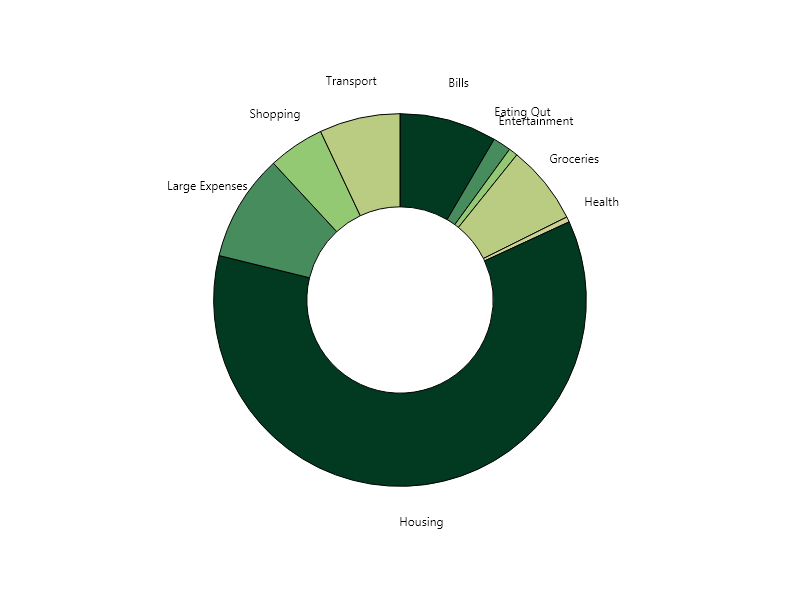

In [16]:
ScottPlot.Plot myPlot = new();

var palette = new ScottPlot.Palettes.Nero();

List<PieSlice> slices = groupedAmounts.Select((a, i) => new PieSlice() 
{
    Value = decimal.ToDouble(a.Amount),
    Label = a.VendorName,
    FillColor = palette.GetColor(i % palette.Colors.Count()), 
}).ToList();

var pie = myPlot.Add.Pie(slices);
pie.DonutFraction = .5;

myPlot.ShowLegend();

myPlot.Axes.Frameless();
myPlot.HideGrid();

Console.WriteLine($"Displaying spending by category for {personName}");

Console.WriteLine("Large Expenses:");
for (var i = 0; i < largeExpenses.Count; i++)
{
    var (amount, date, outlet) = largeExpenses[i];
    Console.WriteLine($"£{amount} | {date.ToShortDateString()} | {outlet}");
}

myPlot

Displaying last months spending by category for Jennifer Anderson



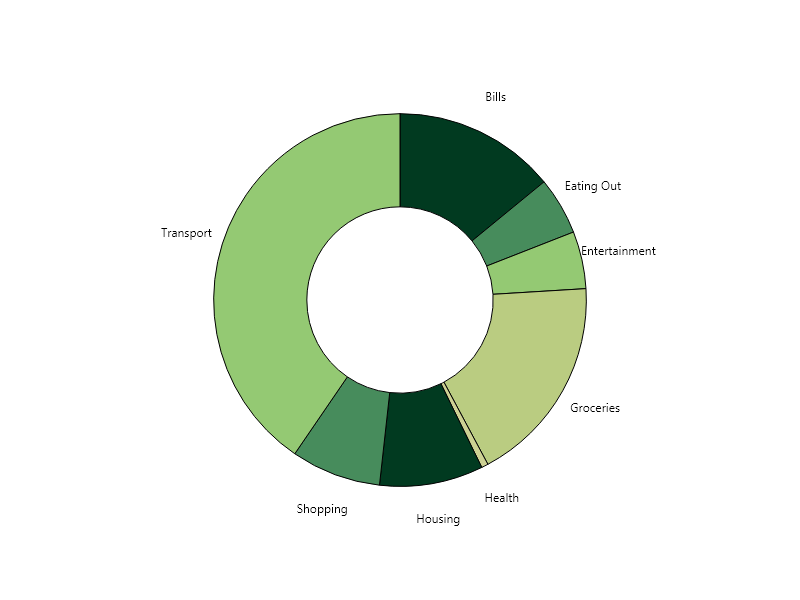

In [5]:
ScottPlot.Plot monthPlot = new();

var palette = new ScottPlot.Palettes.Nero();

List<PieSlice> slices = groupedLastMonth.Select((a, i) => new PieSlice() 
{
    Value = decimal.ToDouble(a.Amount),
    Label = a.VendorName,
    FillColor = palette.GetColor(i % palette.Colors.Count()), 
}).ToList();

var pie = monthPlot.Add.Pie(slices);
pie.DonutFraction = .5;

monthPlot.ShowLegend();

monthPlot.Axes.Frameless();
monthPlot.HideGrid();

Console.WriteLine($"Displaying last months spending by category for {personName}");

monthPlot

In [10]:
// display repeat transactions

Console.WriteLine($"Displaying totals of repeat transactions for {personName} (in last 3 months) :");

foreach (var (amount, outlet, category) in recurring)
{
    Console.WriteLine($"£{amount} | {outlet} | {category}");
}


Displaying totals of repeat transactions for Jennifer Anderson (in last 3 months) :
£3857.97 | Rent Payment | Housing
£272.36 | Shell Petrol | Transport
£228.40 | BP Petrol | Transport
£124.03 | Tesco | Groceries
£93.15 | London Underground | Transport
£87.12 | Sainsbury's | Groceries
£68.81 | Aldi | Groceries
£36.59 | Uber | Transport
£35.72 | First Bus | Transport
£30.56 | Spotify | Entertainment
£23.49 | Amazon Prime | Entertainment
£18.93 | Costa Coffee | Eating Out


Lowest balance: -5750.612749999998, Highest balance: 2001.0427499999998



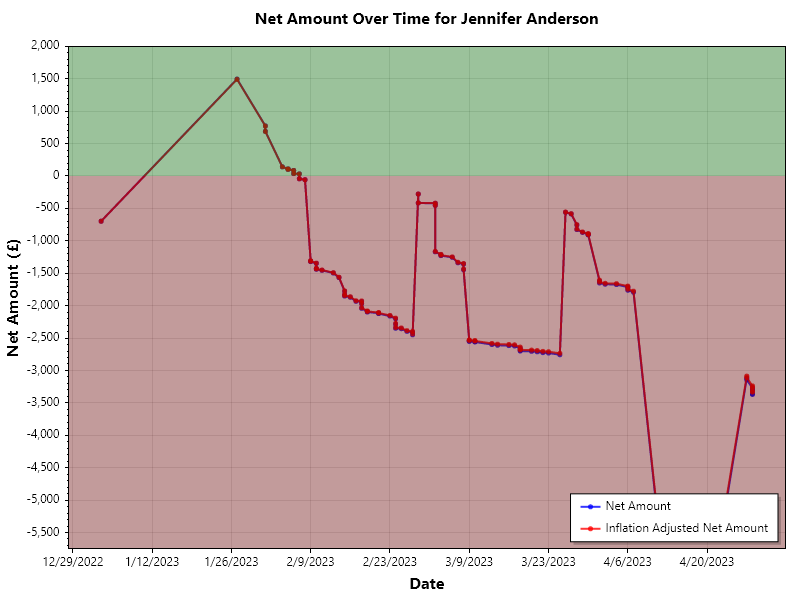

In [11]:
// Prepare data
var dates = transactions.Select(t => t.Date).ToArray();
var netAmounts = transactions.Select(t => t.TransactionType == "income" ? t.Amount : -t.Amount).ToArray();

var inflationRate = 0.036; // Example inflation rate of 3.6%



// Calculate cumulative net amount over time
double[] cumulativeNet = new double[netAmounts.Length];
double[] cumulativeNetInflationAdjusted = new double[netAmounts.Length];
DateTime startDate = dates.Min();
double sum = 0;
for (int i = 0; i < netAmounts.Length; i++)
{
    sum += (double)netAmounts[i];
    cumulativeNet[i] = sum;

    // Calculate years since start for inflation adjustment
    double yearsSinceStart = (dates[i] - startDate).TotalDays / 365.25;
    double inflationMultiplier = Math.Pow(1 + inflationRate, yearsSinceStart);
    cumulativeNetInflationAdjusted[i] = sum / inflationMultiplier;
}

// Plot
ScottPlot.Plot myPlot = new();

var scatterNet = myPlot.Add.Scatter(dates, cumulativeNet);
scatterNet.LineWidth = 2;
scatterNet.Color = new ScottPlot.Color(0, 0, 255, 200); // Blue line for net amount
scatterNet.Label = "Net Amount"; // Add label for legend

var scatterInflation = myPlot.Add.Scatter(dates, cumulativeNetInflationAdjusted);
scatterInflation.LineWidth = 2;
scatterInflation.Color = new ScottPlot.Color(255, 0, 0, 200); // Red line for inflation-adjusted net amount
scatterInflation.Label = "Inflation Adjusted Net Amount"; // Add label for legend

// Set DateTime ticks on the bottom axis
myPlot.Axes.DateTimeTicksBottom();

// Highlight positive and negative regions
AxisLimits limits = myPlot.Axes.GetLimits();

double yMin = limits.Bottom;;
double yMax = limits.Top;

Console.WriteLine($"Lowest balance: {yMin}, Highest balance: {yMax}");

if (yMax > 0)
    myPlot.Add.VerticalSpan(0, yMax).FillColor = new ScottPlot.Color(0, 100, 0, 100);		

if (yMin < 0)
    myPlot.Add.VerticalSpan(yMin, 0).FillColor = new ScottPlot.Color(100, 0, 0, 100);


myPlot.Title($"Net Amount Over Time for {personName}");
myPlot.YLabel("Net Amount (£)");
myPlot.XLabel("Date");
myPlot.ShowLegend();



// Display the plot
myPlot

Lowest balance: -11420.543190551185, Highest balance: 2396.619292364036



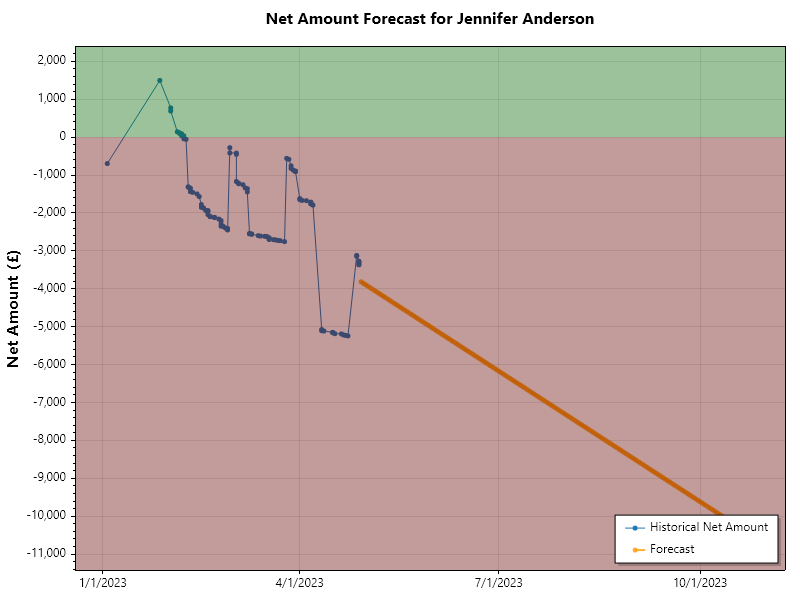

In [12]:
// Prepare data
var dates = transactions.Select(t => t.Date).ToArray();
var netAmounts = transactions.Select(t => t.TransactionType == "income" ? t.Amount : -t.Amount).ToArray();

// Calculate cumulative net amount over time
double[] cumulativeNet = new double[netAmounts.Length];
DateTime startDate = dates.Min();
double sum = 0;
for (int i = 0; i < netAmounts.Length; i++)
{
    sum += (double)netAmounts[i];
    cumulativeNet[i] = sum;
}

// 1. Prepare data for regression (convert dates to numeric values)
double[] x = dates.Select(d => d.Subtract(startDate).TotalDays).ToArray();
double[] y = cumulativeNet;

// 2. Calculate linear regression coefficients (y = a + b*x)
double xMean = x.Average();
double yMean = y.Average();
double b = x.Zip(y, (xi, yi) => (xi - xMean) * (yi - yMean)).Sum() / x.Select(xi => Math.Pow(xi - xMean, 2)).Sum();
double a = yMean - b * xMean;

// 3. Predict future dates (e.g., next 180 days)
int futureDays = 180;
var lastDate = dates.Max();
var futureDates = Enumerable.Range(1, futureDays).Select(i => lastDate.AddDays(i)).ToArray();
double[] futureX = futureDates.Select(d => d.Subtract(startDate).TotalDays).ToArray();
double[] predictedY = futureX.Select(xi => a + b * xi).ToArray();

// 4. Plot historical and predicted net amounts
ScottPlot.Plot forecastPlot = new();


var historical = forecastPlot.Add.Scatter(dates, cumulativeNet);
historical.Label = "Historical Net Amount"; // Add label for legend


List<LinePattern> patterns = [];
patterns.Add(LinePattern.Dashed);

var forecast = forecastPlot.Add.Scatter(futureDates, predictedY);





forecast.LineWidth = 2; // Set line width for better visibility
forecast.Color = new ScottPlot.Color(255, 153, 0, 200); // Orange color for forecast line
forecast.Label = "Forecast"; // Add label for legend
forecast.LinePattern = patterns[0]; // Set line style for forecast

// Add labels and legend
forecastPlot.Title($"Net Amount Forecast for {personName}");
forecastPlot.YLabel("Net Amount (£)");
forecastPlot.XLabel("Date");
forecastPlot.ShowLegend();


// Set DateTime ticks on the bottom axis
forecastPlot.Axes.DateTimeTicksBottom();

// Highlight positive and negative regions
AxisLimits limits = forecastPlot.Axes.GetLimits();

double yMin = limits.Bottom;;
double yMax = limits.Top;

Console.WriteLine($"Lowest balance: {yMin}, Highest balance: {yMax}");

if (yMax > 0)
    forecastPlot.Add.VerticalSpan(0, yMax).FillColor = new ScottPlot.Color(0, 100, 0, 100);		

if (yMin < 0)
    forecastPlot.Add.VerticalSpan(yMin, 0).FillColor = new ScottPlot.Color(100, 0, 0, 100);



// Display the plot
forecastPlot